# Toy feedforward GAN, MNIST dataset

### New concepts:
• Tanh regularization

• BCE Loss function

• Leaky Relu

In [0]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image
from matplotlib import pyplot as plt

In [1]:
#Parameters
latent_size = 64
hidden_size = 256
image_size = 28*28
num_epochs = 100
batch_size = 100
sample_dir = 'feedforward_mnist_gan/samples'

#Normalization of images
mean = 0.5
std = 0.5
    
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)    

### Dataset loading, inspecting

In [2]:
train_dataset = torchvision.datasets.MNIST(root='mnist/', download=False)
raw_data = [data for data in train_dataset]

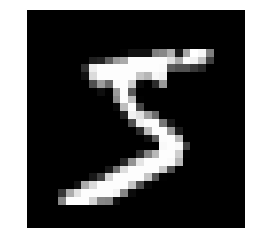

label: 5


In [3]:
plt.imshow(raw_data[0][0], cmap = 'gray')
plt.axis('off')
plt.show()
print("label: {}".format(raw_data[0][1]))

### Data loader

In [4]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean = (mean,), std = (std,))])
tensor_data = [ [transform(xy[0]), xy[1]] for xy in raw_data ]   
train_loader = torch.utils.data.DataLoader(tensor_data, batch_size=batch_size, shuffle=True)

### Discriminator and Generator architectures

In [5]:
# Discriminator
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())
    
# Generator 
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())


# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)



In [6]:
#denormalize the images
def denorm(x):
    out = x*0.5 + 0.5
    return out.clamp(0, 1)

#reset gradients of both nets
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

# Start training
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(train_loader):
        
        #reshape images accordingly, to fit input layer
        images = images.reshape(batch_size, -1)
        
        # Create the labels which are later used as input for the BCE loss
        
        #real labels, all 1s
        real_labels = torch.ones(batch_size, 1)
        
        #fake lables, all 0s
        fake_labels = torch.zeros(batch_size, 1)
        
        
        #### Train the Discriminator Network ####
        

        #discriminate real images
        outputs = D(images)
        #Compute BCE Loss using the real images:
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        #fake images generation
        #input random vector
        z = torch.randn(batch_size, latent_size)
        fake_images = G(z)
        #discriminate fake images
        outputs = D(fake_images)
        #Compute BCELoss using fake images        
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # Backprop and optimize
        d_loss = d_loss_real + d_loss_fake
        reset_grad()
        d_loss.backward()
        d_optimizer.step()
        
        #### Train the Generator Network ####

        #fake images generation
        z = torch.randn(batch_size, latent_size)
        fake_images = G(z)
        #discriminate fake images
        outputs = D(fake_images)
        #Compute loss with fake images
        #the Generator is trained so that D will predict the fake images as real ones!
        g_loss = criterion(outputs, real_labels)
        
        # Backprop and optimize
        reset_grad()
        g_loss.backward()
        g_optimizer.step()
        
    
    # Save real images
    if (epoch+1) == 1:
        images = images.reshape(images.size(0), 1, 28, 28)
        save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))
    
    # Save sampled images
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    save_image(denorm(fake_images), os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))


### Saving the models

In [7]:
# Save the model checkpoints 
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

### Some results!
#### After 90 epochs:

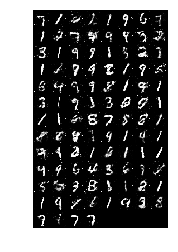

In [8]:
img = plt.imread(sample_dir + '/fake_images-90.png' )
plt.imshow(img)
plt.axis('off')
plt.show()